In [2]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 102.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
blosc2 3.5.1 requires numpy>=1.26, but you have numpy 1.

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0 | Reward: 20.00


Saved video: ./gae_videos/episode_0.mp4
Episode 10 | Reward: 17.00
Episode 20 | Reward: 18.00
Episode 30 | Reward: 19.00
Episode 40 | Reward: 23.00
Episode 50 | Reward: 22.00


Saved video: ./gae_videos/episode_50.mp4
Episode 60 | Reward: 11.00
Episode 70 | Reward: 16.00
Episode 80 | Reward: 17.00


Episode 90 | Reward: 14.00
Episode 100 | Reward: 11.00
Saved video: ./gae_videos/episode_100.mp4
Episode 110 | Reward: 13.00
Episode 120 | Reward: 14.00
Episode 130 | Reward: 11.00


Episode 140 | Reward: 17.00
Episode 150 | Reward: 12.00
Saved video: ./gae_videos/episode_150.mp4
Episode 160 | Reward: 9.00
Episode 170 | Reward: 9.00


Episode 180 | Reward: 9.00
Episode 190 | Reward: 12.00
Episode 200 | Reward: 11.00
Saved video: ./gae_videos/episode_200.mp4
Episode 210 | Reward: 8.00
Episode 220 | Reward: 9.00


Episode 230 | Reward: 9.00
Episode 240 | Reward: 9.00
Episode 250 | Reward: 8.00
Saved video: ./gae_videos/episode_250.mp4
Episode 260 | Reward: 10.00
Episode 270 | Reward: 9.00
Episode 280 | Reward: 8.00


Episode 290 | Reward: 9.00
Episode 300 | Reward: 9.00
Saved video: ./gae_videos/episode_300.mp4
Episode 310 | Reward: 8.00
Episode 320 | Reward: 9.00
Episode 330 | Reward: 9.00
Episode 340 | Reward: 9.00


Episode 350 | Reward: 8.00
Saved video: ./gae_videos/episode_350.mp4
Episode 360 | Reward: 10.00
Episode 370 | Reward: 9.00
Episode 380 | Reward: 10.00
Episode 390 | Reward: 10.00


Episode 400 | Reward: 10.00
Saved video: ./gae_videos/episode_400.mp4
Episode 410 | Reward: 10.00
Episode 420 | Reward: 10.00
Episode 430 | Reward: 10.00
Episode 440 | Reward: 10.00


Episode 450 | Reward: 8.00
Saved video: ./gae_videos/episode_450.mp4
Episode 460 | Reward: 10.00
Episode 470 | Reward: 10.00
Episode 480 | Reward: 9.00
Episode 490 | Reward: 9.00


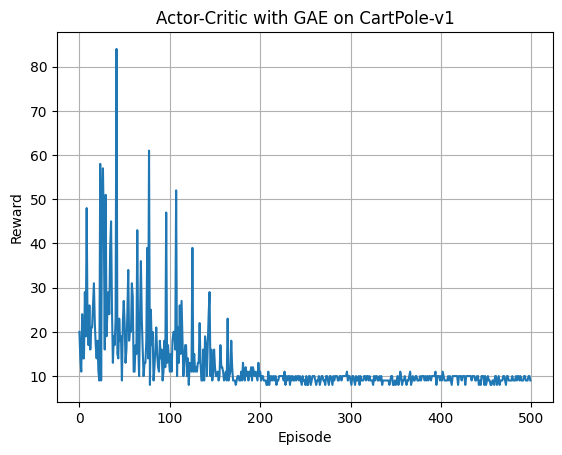

In [9]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# --- Настройки ---
ENV_NAME = "CartPole-v1"
GAMMA = 0.99
LAMBDA = 0.95
LR = 1e-3
EPISODES = 500
VIDEO_INTERVAL = 50
SAVE_DIR = "./gae_videos"
os.makedirs(SAVE_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Актор-Критик модель ---
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
        )
        self.policy = nn.Linear(128, action_dim)
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)

# --- Generalized Advantage Estimation ---
def compute_gae(rewards, values, next_value, gamma=GAMMA, lam=LAMBDA):
    values = values + [next_value]
    gae = 0
    returns = []
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] - values[t]
        gae = delta + gamma * lam * gae
        returns.insert(0, gae + values[t])
    advantages = [ret - val for ret, val in zip(returns, values[:-1])]
    return returns, advantages

# --- Видеозапись ---
def record_video(env, model, episode):
    frames = []
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode="rgb_array")
        frames.append(frame)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        logits, _ = model(state_tensor)
        dist = Categorical(logits=logits)
        action = dist.sample().item()
        state, _, done, _ = env.step(action)
    filename = os.path.join(SAVE_DIR, f"episode_{episode}.mp4")
    imageio.mimsave(filename, frames, fps=30)
    print(f"Saved video: {filename}")

# --- Обучающий цикл ---
def train():
    env = gym.make(ENV_NAME)
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    model = ActorCritic(obs_dim, action_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    reward_history = []

    for episode in range(EPISODES):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []

        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            logits, value = model(state_tensor)
            dist = Categorical(logits=logits)
            action = dist.sample()

            next_state, reward, done, _ = env.step(action.item())

            log_probs.append(dist.log_prob(action))
            values.append(value.squeeze())
            rewards.append(reward)

            total_reward += reward
            state = next_state

        # Последнее значение (bootstrap)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
        _, next_value = model(next_state_tensor)
        next_value = next_value.squeeze().detach()

        returns, advantages = compute_gae(rewards, [v.detach() for v in values], next_value)

        log_probs = torch.stack(log_probs)
        values = torch.stack(values)
        returns = torch.tensor(returns).to(device)
        advantages = torch.tensor(advantages).to(device)

        actor_loss = -(log_probs * advantages.detach()).mean()
        critic_loss = (returns - values).pow(2).mean()
        loss = actor_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reward_history.append(total_reward)

        if episode % 10 == 0:
            print(f"Episode {episode} | Reward: {total_reward:.2f}")

        if episode % VIDEO_INTERVAL == 0:
            record_video(env, model, episode)

    env.close()

    # --- Визуализация ---
    plt.plot(reward_history)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Actor-Critic with GAE on " + ENV_NAME)
    plt.grid()
    plt.show()

if __name__ == "__main__":
    train()
